### Using GANs to Generate Handwritten Digits

#### Import Relevant Packages and Define the Device

In [28]:
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch import nn, optim
from torchsummary import summary
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Import the Dataset and Define the Dataloader

In [29]:
transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize((0.5,), (0.5,))
])

In [30]:
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)

In [31]:
train_data_dl = DataLoader(train_dataset, batch_size=128, shuffle=True , drop_last=True)

#### Define the Discriminator Model Class

In [32]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
                                    nn.Linear(784, 1024), 
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Linear(1024, 512),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 256),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid()
                                  )
    
    def forward(self, x):
        x = self.model(x)
        return x

In [33]:
discriminator = Discriminator().to(device)
summary(discriminator, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         803,840
         LeakyReLU-2              [-1, 1, 1024]               0
           Dropout-3              [-1, 1, 1024]               0
            Linear-4               [-1, 1, 512]         524,800
         LeakyReLU-5               [-1, 1, 512]               0
           Dropout-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
         LeakyReLU-8               [-1, 1, 256]               0
           Dropout-9               [-1, 1, 256]               0
           Linear-10                 [-1, 1, 1]             257
          Sigmoid-11                 [-1, 1, 1]               0
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

#### Define the Generator Model Class

In [34]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                                   nn.Linear(100, 256),
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(256, 512),
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(512, 1024),
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(1024, 784),
                                   nn.Tanh()
                                    )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [35]:
generator  = Generator().to(device)
summary(generator, (1,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          25,856
         LeakyReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 512]         131,584
         LeakyReLU-4               [-1, 1, 512]               0
            Linear-5              [-1, 1, 1024]         525,312
         LeakyReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 784]         803,600
              Tanh-8               [-1, 1, 784]               0
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.67
Estimated Total Size (MB): 5.71
----------------------------------------------------------------


#### Define A random Noise Generation Function 

In [36]:
def generate_noise(size):
    n = torch.randn(size, 100)
    return n.to(device)

#### Define Optimizers and Loss Function

In [37]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()
num_epochs = 500
log = Report(num_epochs)

#### Define a function to Train the Discriminator 

In [38]:
def discriminator_train_step(real_data, fake_data):
    #reset gradients
    discriminator_optimizer.zero_grad()
    # predict on real data
    prediction_real = discriminator(real_data)
    # calculate loss on real
    error_real = loss(prediction_real, torch.ones(len(real_data),1).to(device)).to(device)
    # calculate gradients on real
    error_real.backward()
    # predict on fake data
    prediction_fake = discriminator(fake_data)
    # calculate loss on fake
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data),1).to(device)).to(device)
    # calculate gradients on fake
    error_fake.backward()
    # update weights
    discriminator_optimizer.step()


    return error_real + error_fake
   


#### Train the Generator Model

In [43]:
def generator_train_step(fake_data):
    
    # reset gradients
    generator_optimizer.zero_grad()
    # predict the outpu of the discriminator with the fake data
    prediction = discriminator(fake_data)
    # calculate the loss
    error = loss(prediction, torch.ones(len(fake_data), 1).to(device))
    # backpropagate
    error.backward()
    # update the weights
    generator_optimizer.step()

    return error

#### Train the Model over Increasing Epochs

EPOCH: 1.000  d_loss: 0.880  g_loss: 3.225  (313.37s - 156371.89s remaining)))
EPOCH: 2.000  d_loss: 0.622  g_loss: 4.727  (324.40s - 80774.53s remaining)))
EPOCH: 3.000  d_loss: 0.894  g_loss: 2.125  (335.41s - 55565.54s remaining)
EPOCH: 4.000  d_loss: 0.724  g_loss: 2.461  (346.43s - 42957.42s remaining)
EPOCH: 5.000  d_loss: 0.480  g_loss: 2.995  (357.51s - 35393.00s remaining)
EPOCH: 6.000  d_loss: 0.366  g_loss: 3.587  (368.79s - 30363.39s remaining)
EPOCH: 7.000  d_loss: 0.445  g_loss: 3.720  (379.71s - 26742.20s remaining)
EPOCH: 8.000  d_loss: 0.423  g_loss: 3.431  (390.60s - 24021.82s remaining)
EPOCH: 9.000  d_loss: 0.511  g_loss: 3.115  (401.45s - 21901.36s remaining)
EPOCH: 10.000  d_loss: 0.482  g_loss: 3.036  (412.51s - 20213.02s remaining)
EPOCH: 11.000  d_loss: 0.550  g_loss: 2.704  (423.52s - 18827.36s remaining)
EPOCH: 12.000  d_loss: 0.599  g_loss: 2.633  (434.85s - 17684.03s remaining)
EPOCH: 13.000  d_loss: 0.613  g_loss: 2.485  (445.99s - 16707.40s remaining)
EPO

100%|██████████| 601/601 [00:22<00:00, 26.93it/s] 


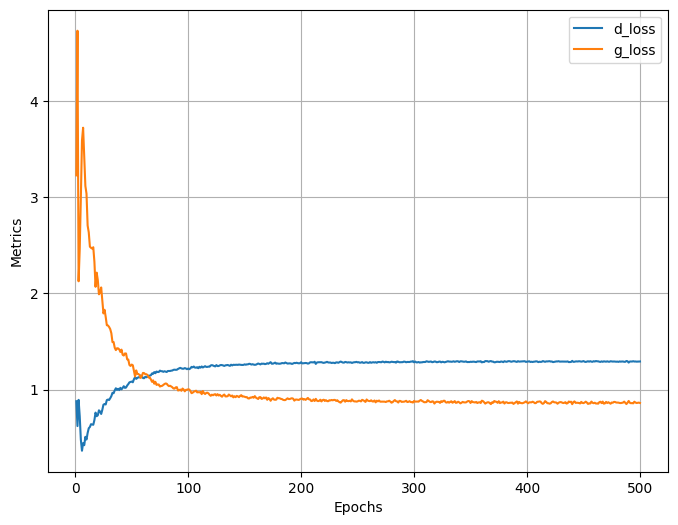

In [45]:
for epoch in range(num_epochs):
    N = len(train_data_dl)

    for i, (images,_) in enumerate(train_data_dl):
        real_images = images.view(len(images), -1).to(device)
        fake_images = generator(generate_noise(len(real_images))).to(device)
        fake_images = fake_images.detach()
        discriminator_loss = discriminator_train_step(real_images, fake_images)
        fake_images = generator(generate_noise(len(real_images))).to(device)
        generator_loss = generator_train_step(fake_images)

        log.record(epoch+(1+i)/N, d_loss = discriminator_loss.item(), g_loss = generator_loss.item() , end = '\r')
    
    log.report_avgs(epoch+1)

log.plot_epochs(['d_loss', 'g_loss'])

#### Visualize the fake data post-training

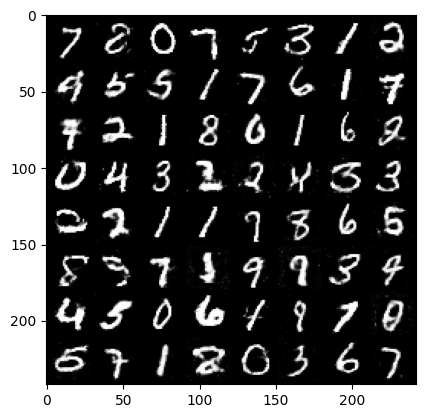

In [50]:
z = torch.randn(64, 100).to(device)
sample_images = generator(z).data.cpu().view(64, 1, 28, 28)
grid = make_grid(sample_images, nrow=8, normalize=True).permute(1,2,0)
plt.imshow(grid.cpu().detach().numpy(), cmap='gray')